In [18]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [45]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)

## Data cleaning

In [46]:
from helpers import *

# find indices of features that have at least one value -999, we call them "bad" features
idx_badFeatures = []
for d in range(X.shape[1]):
    if sum(X[:,d] == -999) > 0:
        idx_badFeatures.append(d)
        
# separate "good" and "bad" features
X_badFeatures = X[:,idx_badFeatures]
X_goodFeatures = np.delete(X,(idx_badFeatures), axis=1)

# Function that calculate the mean and std of bad features without elements equal to -999
# Then, it remplaces -999 values by zeros, zeros won't influence the train of the model... 
def standardize_badFeatures(X):
    mean_x = np.zeros((X.shape[1],))
    std_x = np.zeros((X.shape[1],))
    for d in range(X.shape[1]):
        idx = np.where(X[:,d] == -999)
        mean_x[d] = np.mean(np.delete(X[:,d], (idx)))
        std_x[d] = np.std(np.delete(X[:,d], (idx)))
        X[:,d] = (X[:,d]-mean_x[d])/std_x[d]
        X[idx,d] = 0
    return X, mean_x, std_x

tX, mean_x, std_x = standardize(X_goodFeatures)
tX2, mean_x2, std_x2 = standardize_badFeatures(X_badFeatures)

# comment the 3 next lines if you want to work only with the 19 "good" features
#tX = np.hstack((tX, tX2))
#mean_x = np.hstack((mean_x, mean_x2))
#std_x = np.hstack((std_x, std_x2))

In [37]:
# look for outliers (> 40*std)
#outliers = np.where(tX > 40)
# here we see that our single outlier is in fact a higgs boson event...
# should we keep it ???
#print(outliers[0], y[outliers[0]])
#plt.boxplot(tX)
#np.sum(y == 1)/len(y), np.sum(y == -1)/len(y)

print(np.arange(1,3))
#Is there samples that are identical ?
#ncols = tX.shape[1]
#dtype = tX.dtype.descr * ncols
#struct = tX.view(dtype)

#uniq, idx = np.unique(struct, return_index=True)
#tX = uniq.view(tX.dtype).reshape(-1, ncols)

#print(tX.shape)
            

[1 2]


# Least Squares regression

NameError: name 'degrees' is not defined

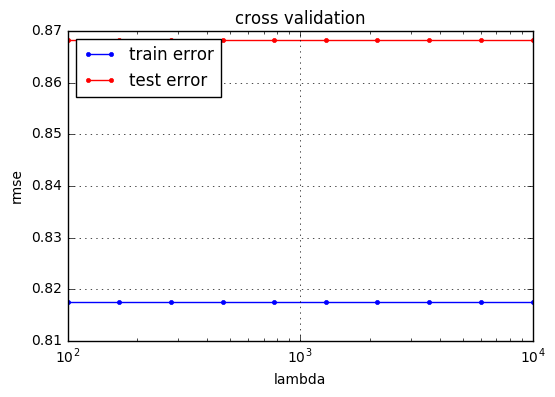

In [47]:
import myFunctions as my
from plots import cross_validation_visualization

def cross_validation(y, x, k_indices, k, degree, lamb):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train: TODO
    x_tr = x[np.delete(k_indices, (k), axis=0).flatten()]
    y_tr = y[np.delete(k_indices, (k), axis=0).flatten()]
    x_te = x[k_indices[k]]
    y_te = y[k_indices[k]]
    
    # form data with polynomial degree: TODO
    tx_tr = my.build_poly(x_tr, degree)
    tx_te = my.build_poly(x_te, degree)
    
    # regression/classification method
    w = my.ridge_regression(y_tr, tx_tr, lamb)
    
    # calculate the loss for train and test data: TODO
    loss_tr = my.compute_loss(y_tr, tx_tr, w)
    loss_te = my.compute_loss(y_te, tx_te, w)
    
    return loss_tr, loss_te

def cross_validation_demo():
    # parameters
    seed = 5
    k_fold = 10
    
    # hyperparameters
    degree = 2
    lambdas = np.logspace(2, 4, 10)
    
    # split data in k fold
    k_indices = my.build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    for lamb in lambdas:
        cost_tr = []
        cost_te = []
            
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, tX, k_indices, k, degree, lamb)
            cost_tr.append(loss_tr)
            cost_te.append(loss_te)
                
        rmse_tr.append(np.mean(cost_tr))
        rmse_te.append(np.mean(cost_te))
        var_tr.append(np.std(cost_tr))
        var_te.append(np.std(cost_te))
        
        #best_rmse.append(min(rmse_te))
        #best_lambda.append(lambdas[np.argmin(np.array(rmse_te))])
        
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    return rmse_tr, rmse_te, var_tr, var_te, lambdas

rmse_tr, rmse_te, var_tr, var_te, lambdas = cross_validation_demo()
plt.errorbar(2, rmse_te, var_te)


AssertionError: 

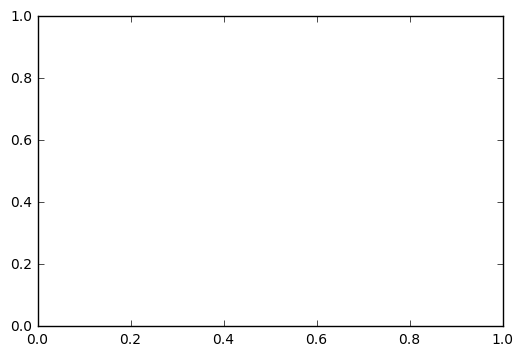

In [48]:
plt.errorbar(2, rmse_te, var_te)

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)